# Chapter 25 - Preprocessing and Feature Engineering

Check the official documentation site for `pyspark.ml.feature` for the most recent version of Spark (or the one that you have installed).

http://spark.apache.org/docs/2.4.0/api/python/pyspark.ml.html#module-pyspark.ml.feature

## Loading the Input Datasets

In [1]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.master("local").appName("chapter25").getOrCreate()

In [2]:
sales = spark.read.format("csv").option("header", "true")\
                                .option("inferSchema", "true")\
                                .option("path", "../data/retail-data/by-day/*.csv")\
                                .load().coalesce(5).where("Description IS NOT NULL")
sales.cache()  # make it persistent, since we will be using it later
sales.show()

+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+
|InvoiceNo|StockCode|         Description|Quantity|        InvoiceDate|UnitPrice|CustomerID|       Country|
+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+
|   580538|    23084|  RABBIT NIGHT LIGHT|      48|2011-12-05 08:38:00|     1.79|   14075.0|United Kingdom|
|   580538|    23077| DOUGHNUT LIP GLOSS |      20|2011-12-05 08:38:00|     1.25|   14075.0|United Kingdom|
|   580538|    22906|12 MESSAGE CARDS ...|      24|2011-12-05 08:38:00|     1.65|   14075.0|United Kingdom|
|   580538|    21914|BLUE HARMONICA IN...|      24|2011-12-05 08:38:00|     1.25|   14075.0|United Kingdom|
|   580538|    22467|   GUMBALL COAT RACK|       6|2011-12-05 08:38:00|     2.55|   14075.0|United Kingdom|
|   580538|    21544|SKULLS  WATER TRA...|      48|2011-12-05 08:38:00|     0.85|   14075.0|United Kingdom|
|   580538|    23126|FELTCRA

In [3]:
fakeIntDF = spark.read.parquet("../data/simple-ml-integers")
fakeIntDF.show()

+----+----+----+
|int1|int2|int3|
+----+----+----+
|   1|   2|   3|
|   4|   5|   6|
|   7|   8|   9|
+----+----+----+



In [4]:
simpleDF = spark.read.json("../data/simple-ml")
simpleDF.show()

+-----+----+------+------------------+
|color| lab|value1|            value2|
+-----+----+------+------------------+
|green|good|     1|14.386294994851129|
| blue| bad|     8|14.386294994851129|
| blue| bad|    12|14.386294994851129|
|green|good|    15| 38.97187133755819|
|green|good|    12|14.386294994851129|
|green| bad|    16|14.386294994851129|
|  red|good|    35|14.386294994851129|
|  red| bad|     1| 38.97187133755819|
|  red| bad|     2|14.386294994851129|
|  red| bad|    16|14.386294994851129|
|  red|good|    45| 38.97187133755819|
|green|good|     1|14.386294994851129|
| blue| bad|     8|14.386294994851129|
| blue| bad|    12|14.386294994851129|
|green|good|    15| 38.97187133755819|
|green|good|    12|14.386294994851129|
|green| bad|    16|14.386294994851129|
|  red|good|    35|14.386294994851129|
|  red| bad|     1| 38.97187133755819|
|  red| bad|     2|14.386294994851129|
+-----+----+------+------------------+
only showing top 20 rows



In [5]:
scaleDF = spark.read.parquet("../data/simple-ml-scaling")
scaleDF.show()

+---+--------------+
| id|      features|
+---+--------------+
|  0|[1.0,0.1,-1.0]|
|  1| [2.0,1.1,1.0]|
|  0|[1.0,0.1,-1.0]|
|  1| [2.0,1.1,1.0]|
|  1|[3.0,10.1,3.0]|
+---+--------------+



### Transformers and Estimators

**Transformers** do not depend on the input data, but they work for any dataset. An example would be a tokenizer. Transformers have a `transform()` method.

**Estimators** can be used for preprocessing and depend on the input data, thus they have a `fit()` method. After the method `tranform()` would be called. An example is a Standard Scaler.

In [6]:
from pyspark.ml.feature import Tokenizer

tkn = Tokenizer(inputCol="Description")
tkn.transform(sales.select("Description")).show()

+--------------------+--------------------------------------+
|         Description|Tokenizer_4c03a9c1298975c4937e__output|
+--------------------+--------------------------------------+
|  RABBIT NIGHT LIGHT|                  [rabbit, night, l...|
| DOUGHNUT LIP GLOSS |                  [doughnut, lip, g...|
|12 MESSAGE CARDS ...|                  [12, message, car...|
|BLUE HARMONICA IN...|                  [blue, harmonica,...|
|   GUMBALL COAT RACK|                  [gumball, coat, r...|
|SKULLS  WATER TRA...|                  [skulls, , water,...|
|FELTCRAFT GIRL AM...|                  [feltcraft, girl,...|
|CAMOUFLAGE LED TORCH|                  [camouflage, led,...|
|WHITE SKULL HOT W...|                  [white, skull, ho...|
|ENGLISH ROSE HOT ...|                  [english, rose, h...|
|HOT WATER BOTTLE ...|                  [hot, water, bott...|
|SCOTTIE DOG HOT W...|                  [scottie, dog, ho...|
|ROSE CARAVAN DOOR...|                  [rose, caravan, d...|
|GINGHAM

In [7]:
from pyspark.ml.feature import StandardScaler

ss = StandardScaler(inputCol="features")
ss.fit(scaleDF).transform(scaleDF).show()

+---+--------------+-------------------------------------------+
| id|      features|StandardScaler_466c92924d19a3a9964e__output|
+---+--------------+-------------------------------------------+
|  0|[1.0,0.1,-1.0]|                       [1.19522860933439...|
|  1| [2.0,1.1,1.0]|                       [2.39045721866878...|
|  0|[1.0,0.1,-1.0]|                       [1.19522860933439...|
|  1| [2.0,1.1,1.0]|                       [2.39045721866878...|
|  1|[3.0,10.1,3.0]|                       [3.58568582800318...|
+---+--------------+-------------------------------------------+



## High-level transformers

As a general principle, you should aim to:

* Always use high-level transformers, avoid re-implemeting since the implementation has been optimized for Spark.
* Use the highest level transformer available.

### RFormula

This has been already demoed in [Chapter 24](https://github.com/drublackberry/Spark-The-Definitive-Guide/blob/master/notebook/Chapter24.ipynb) but it is reshown here for consistency. To understand it better some help can be found [here](https://spark.apache.org/docs/latest/ml-features.html#rformula)

In [8]:
from pyspark.ml.feature import RFormula

supervised = RFormula(formula="lab ~ . + color:value1 + color:value2")
foo = supervised.fit(simpleDF).transform(simpleDF)
foo.show()
foo.take(1)

+-----+----+------+------------------+--------------------+-----+
|color| lab|value1|            value2|            features|label|
+-----+----+------+------------------+--------------------+-----+
|green|good|     1|14.386294994851129|(10,[1,2,3,5,8],[...|  1.0|
| blue| bad|     8|14.386294994851129|(10,[2,3,6,9],[8....|  0.0|
| blue| bad|    12|14.386294994851129|(10,[2,3,6,9],[12...|  0.0|
|green|good|    15| 38.97187133755819|(10,[1,2,3,5,8],[...|  1.0|
|green|good|    12|14.386294994851129|(10,[1,2,3,5,8],[...|  1.0|
|green| bad|    16|14.386294994851129|(10,[1,2,3,5,8],[...|  0.0|
|  red|good|    35|14.386294994851129|(10,[0,2,3,4,7],[...|  1.0|
|  red| bad|     1| 38.97187133755819|(10,[0,2,3,4,7],[...|  0.0|
|  red| bad|     2|14.386294994851129|(10,[0,2,3,4,7],[...|  0.0|
|  red| bad|    16|14.386294994851129|(10,[0,2,3,4,7],[...|  0.0|
|  red|good|    45| 38.97187133755819|(10,[0,2,3,4,7],[...|  1.0|
|green|good|     1|14.386294994851129|(10,[1,2,3,5,8],[...|  1.0|
| blue| ba

[Row(color='green', lab='good', value1=1, value2=14.386294994851129, features=SparseVector(10, {1: 1.0, 2: 1.0, 3: 14.3863, 5: 1.0, 8: 14.3863}), label=1.0)]

### SQL transformer
Just remember to use the keyword `__THIS__` to refer to the table name.

In [9]:
from pyspark.ml.feature import SQLTransformer

basicTransform = SQLTransformer()\
                .setStatement("""SELECT sum(Quantity), count(*), CustomerID FROM __THIS__ GROUP BY CustomerID""")
basicTransform.transform(sales).show()

+-------------+--------+----------+
|sum(Quantity)|count(1)|CustomerID|
+-------------+--------+----------+
|          119|      62|   14452.0|
|          440|     143|   16916.0|
|          630|      72|   17633.0|
|           34|       6|   14768.0|
|         1542|      30|   13094.0|
|          854|     117|   17884.0|
|           97|      12|   16596.0|
|          290|      98|   13607.0|
|          541|      27|   14285.0|
|          244|      31|   16561.0|
|          491|     152|   13956.0|
|          204|      76|   13533.0|
|          493|      64|   16629.0|
|          159|      38|   17267.0|
|         1140|      30|   13918.0|
|           55|      28|   18114.0|
|           88|       7|   14473.0|
|          150|      16|   14024.0|
|          206|      23|   12493.0|
|          138|      18|   15776.0|
+-------------+--------+----------+
only showing top 20 rows



### VectorAssembler
It assembles the values into a `Vector` of features that can be fed to an Estimator.

In [10]:
from pyspark.ml.feature import VectorAssembler

va = VectorAssembler(inputCols=["int1", "int2", "int3"])
va.transform(fakeIntDF).show()

+----+----+----+--------------------------------------------+
|int1|int2|int3|VectorAssembler_47b4a41a1854e456259e__output|
+----+----+----+--------------------------------------------+
|   1|   2|   3|                               [1.0,2.0,3.0]|
|   4|   5|   6|                               [4.0,5.0,6.0]|
|   7|   8|   9|                               [7.0,8.0,9.0]|
+----+----+----+--------------------------------------------+



## Working with Continuous Features

### Bucketing

#### Bucketizer
Splits according to defined buckets.

In [11]:
contDF = spark.range(20).selectExpr("cast(id as double)")
contDF.show()

+----+
|  id|
+----+
| 0.0|
| 1.0|
| 2.0|
| 3.0|
| 4.0|
| 5.0|
| 6.0|
| 7.0|
| 8.0|
| 9.0|
|10.0|
|11.0|
|12.0|
|13.0|
|14.0|
|15.0|
|16.0|
|17.0|
|18.0|
|19.0|
+----+



In [12]:
from pyspark.ml.feature import Bucketizer

bucket_borders = [-1., 5., 10., 250., 600.]
bucketer = Bucketizer().setSplits(bucket_borders).setInputCol("id")
bucketer.transform(contDF).show()

+----+---------------------------------------+
|  id|Bucketizer_4d76b5eea808998251f6__output|
+----+---------------------------------------+
| 0.0|                                    0.0|
| 1.0|                                    0.0|
| 2.0|                                    0.0|
| 3.0|                                    0.0|
| 4.0|                                    0.0|
| 5.0|                                    1.0|
| 6.0|                                    1.0|
| 7.0|                                    1.0|
| 8.0|                                    1.0|
| 9.0|                                    1.0|
|10.0|                                    2.0|
|11.0|                                    2.0|
|12.0|                                    2.0|
|13.0|                                    2.0|
|14.0|                                    2.0|
|15.0|                                    2.0|
|16.0|                                    2.0|
|17.0|                                    2.0|
|18.0|       

#### QuantileDiscretizer

Splits in buckets based on quantiles, the input given is the number of quantiles

In [13]:
# bucketing based on Quantiles
from pyspark.ml.feature import QuantileDiscretizer

bucketer = QuantileDiscretizer(numBuckets=5, inputCol="id")
fitted_bucketer = bucketer.fit(contDF)
fitted_bucketer.transform(contDF).show()

+----+------------------------------------------------+
|  id|QuantileDiscretizer_4428a80c01321694f258__output|
+----+------------------------------------------------+
| 0.0|                                             0.0|
| 1.0|                                             0.0|
| 2.0|                                             0.0|
| 3.0|                                             1.0|
| 4.0|                                             1.0|
| 5.0|                                             1.0|
| 6.0|                                             1.0|
| 7.0|                                             2.0|
| 8.0|                                             2.0|
| 9.0|                                             2.0|
|10.0|                                             2.0|
|11.0|                                             2.0|
|12.0|                                             3.0|
|13.0|                                             3.0|
|14.0|                                          

#### Exercise: UnbalancedQuantileDiscretizer

It is a quantile discretizer whose inputs are a quantile array

In [14]:
in_quantiles = [0.5, 0.75, 0.99]

class UnbalancedQuantileDiscretizer:
    
    def __init__(self, quantiles):
        self.quantiles = quantiles
        self.quantile_values = []
        self.inputCol = ''
    
    def fit(self, df_in, inputCol, relativeError=1e-2):
        quantile_values = df_in.approxQuantile(inputCol, self.quantiles, relativeError)
        self.quantile_values = [-float('inf')] + quantile_values + [float('inf')]
        self.inputCol = inputCol
        
    def transform(self, df_in):
        bucketer = Bucketizer().setSplits(self.quantile_values).setInputCol(self.inputCol)
        return bucketer.transform(df_in)
        
bucketer = UnbalancedQuantileDiscretizer(in_quantiles)
bucketer.fit(contDF, "id")
bucketer.transform(contDF).show()

+----+---------------------------------------+
|  id|Bucketizer_416c80ae20dc2ea29e7c__output|
+----+---------------------------------------+
| 0.0|                                    0.0|
| 1.0|                                    0.0|
| 2.0|                                    0.0|
| 3.0|                                    0.0|
| 4.0|                                    0.0|
| 5.0|                                    0.0|
| 6.0|                                    0.0|
| 7.0|                                    0.0|
| 8.0|                                    0.0|
| 9.0|                                    1.0|
|10.0|                                    1.0|
|11.0|                                    1.0|
|12.0|                                    1.0|
|13.0|                                    1.0|
|14.0|                                    2.0|
|15.0|                                    2.0|
|16.0|                                    2.0|
|17.0|                                    2.0|
|18.0|       

In [15]:
basicTransform = SQLTransformer()\
                .setStatement("""SELECT sum(Quantity) AS Total, CustomerID FROM __THIS__ GROUP BY CustomerID""")
    
in_quantiles = [0.25, 0.50, 0.75, 0.95, 0.99]
total_df = basicTransform.transform(sales)

bucketer = UnbalancedQuantileDiscretizer(in_quantiles)
bucketer.fit(total_df, "Total")
total_df = bucketer.transform(total_df)
total_df.show()

+-----+----------+---------------------------------------+
|Total|CustomerID|Bucketizer_4834816aa3128350a6b8__output|
+-----+----------+---------------------------------------+
|  119|   14452.0|                                    0.0|
|  440|   16916.0|                                    2.0|
|  630|   17633.0|                                    2.0|
|   34|   14768.0|                                    0.0|
| 1542|   13094.0|                                    3.0|
|  854|   17884.0|                                    2.0|
|   97|   16596.0|                                    0.0|
|  290|   13607.0|                                    1.0|
|  541|   14285.0|                                    2.0|
|  244|   16561.0|                                    1.0|
|  491|   13956.0|                                    2.0|
|  204|   13533.0|                                    1.0|
|  493|   16629.0|                                    2.0|
|  159|   17267.0|                                    0.

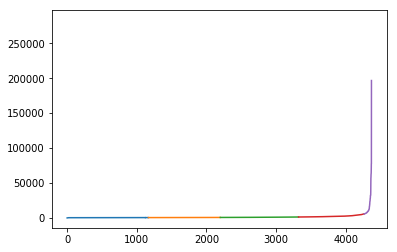

[0.25, 0.5, 0.75, 0.95, 0.99]


In [16]:
import matplotlib.pyplot as plt

pd_df = total_df.toPandas().sort_values(by='Total').reset_index()
buck_col = [x for x in pd_df.columns if "Bucketizer" in x][0]
for b in pd_df[buck_col].unique():
    foo = pd_df.loc[pd_df[buck_col]==b, 'Total'].sort_values()
    plt.plot(foo.index, foo.values)
plt.show()
print(in_quantiles)

## Scaling and normalization

### Standard Scaler


In [17]:
from pyspark.ml.feature import StandardScaler

std_scaler = StandardScaler(inputCol="features")
foo = std_scaler.fit(scaleDF).transform(scaleDF)
foo.show()
foo.take(1)


+---+--------------+-------------------------------------------+
| id|      features|StandardScaler_4f368cd7bde52dbdff2b__output|
+---+--------------+-------------------------------------------+
|  0|[1.0,0.1,-1.0]|                       [1.19522860933439...|
|  1| [2.0,1.1,1.0]|                       [2.39045721866878...|
|  0|[1.0,0.1,-1.0]|                       [1.19522860933439...|
|  1| [2.0,1.1,1.0]|                       [2.39045721866878...|
|  1|[3.0,10.1,3.0]|                       [3.58568582800318...|
+---+--------------+-------------------------------------------+



[Row(id=0, features=DenseVector([1.0, 0.1, -1.0]), StandardScaler_4f368cd7bde52dbdff2b__output=DenseVector([1.1952, 0.0234, -0.5976]))]

### MinMax Scaler

Linearly interpolates between the minimum and maximum values.

In [18]:
from pyspark.ml.feature import MinMaxScaler

min_max = MinMaxScaler(min=5, max=10, inputCol="features")
fitted_min_max = min_max.fit(scaleDF)
foo = fitted_min_max.transform(scaleDF)
foo.show()
foo.take(1)

+---+--------------+-----------------------------------------+
| id|      features|MinMaxScaler_42d9b56298a1c71ff511__output|
+---+--------------+-----------------------------------------+
|  0|[1.0,0.1,-1.0]|                            [5.0,5.0,5.0]|
|  1| [2.0,1.1,1.0]|                            [7.5,5.5,7.5]|
|  0|[1.0,0.1,-1.0]|                            [5.0,5.0,5.0]|
|  1| [2.0,1.1,1.0]|                            [7.5,5.5,7.5]|
|  1|[3.0,10.1,3.0]|                         [10.0,10.0,10.0]|
+---+--------------+-----------------------------------------+



[Row(id=0, features=DenseVector([1.0, 0.1, -1.0]), MinMaxScaler_42d9b56298a1c71ff511__output=DenseVector([5.0, 5.0, 5.0]))]

### MaxAbsScaler
Divides by the maximum value

In [19]:
from pyspark.ml.feature import MaxAbsScaler

max_abs = MaxAbsScaler(inputCol="features")
fitted_max_abs = max_abs.fit(scaleDF)
foo = fitted_max_abs.transform(scaleDF)
foo.show()
foo.take(1)

+---+--------------+-----------------------------------------+
| id|      features|MaxAbsScaler_4e6589ee2c044cea830e__output|
+---+--------------+-----------------------------------------+
|  0|[1.0,0.1,-1.0]|                     [0.33333333333333...|
|  1| [2.0,1.1,1.0]|                     [0.66666666666666...|
|  0|[1.0,0.1,-1.0]|                     [0.33333333333333...|
|  1| [2.0,1.1,1.0]|                     [0.66666666666666...|
|  1|[3.0,10.1,3.0]|                            [1.0,1.0,1.0]|
+---+--------------+-----------------------------------------+



[Row(id=0, features=DenseVector([1.0, 0.1, -1.0]), MaxAbsScaler_4e6589ee2c044cea830e__output=DenseVector([0.3333, 0.0099, -0.3333]))]

### Elementwise Product

All the input vectors (e.g. features) must have the same length as the scale up vectors.

In [20]:
from pyspark.ml.feature import ElementwiseProduct
from pyspark.ml.linalg import Vectors

scale_up_vec = Vectors.dense(10., 15., 20.)
scaling_up = ElementwiseProduct(scalingVec=scale_up_vec, inputCol="features")
foo = scaling_up.transform(scaleDF)
foo.show()
foo.take(1)

+---+--------------+-----------------------------------------------+
| id|      features|ElementwiseProduct_48079f5e8841b56b979b__output|
+---+--------------+-----------------------------------------------+
|  0|[1.0,0.1,-1.0]|                               [10.0,1.5,-20.0]|
|  1| [2.0,1.1,1.0]|                               [20.0,16.5,20.0]|
|  0|[1.0,0.1,-1.0]|                               [10.0,1.5,-20.0]|
|  1| [2.0,1.1,1.0]|                               [20.0,16.5,20.0]|
|  1|[3.0,10.1,3.0]|                              [30.0,151.5,60.0]|
+---+--------------+-----------------------------------------------+



[Row(id=0, features=DenseVector([1.0, 0.1, -1.0]), ElementwiseProduct_48079f5e8841b56b979b__output=DenseVector([10.0, 1.5, -20.0]))]

### Normalizer

The parameter `p` drives this normalizer, being p=2 the euclidean norm and p=1 the manhattan norm

In [21]:
from pyspark.ml.feature import Normalizer

man_distance = Normalizer(p=1, inputCol="features")
foo = man_distance.transform(scaleDF)
foo.show()
foo.take(1)

+---+--------------+---------------------------------------+
| id|      features|Normalizer_4fbb8456ed864621e6e4__output|
+---+--------------+---------------------------------------+
|  0|[1.0,0.1,-1.0]|                   [0.47619047619047...|
|  1| [2.0,1.1,1.0]|                   [0.48780487804878...|
|  0|[1.0,0.1,-1.0]|                   [0.47619047619047...|
|  1| [2.0,1.1,1.0]|                   [0.48780487804878...|
|  1|[3.0,10.1,3.0]|                   [0.18633540372670...|
+---+--------------+---------------------------------------+



[Row(id=0, features=DenseVector([1.0, 0.1, -1.0]), Normalizer_4fbb8456ed864621e6e4__output=DenseVector([0.4762, 0.0476, -0.4762]))]

## Working with Categorical Features

### StringIndexer

In [22]:
from pyspark.ml.feature import StringIndexer

# will transform good to 1. and bad to 0.
lbl_indexer = StringIndexer(inputCol="lab", outputCol="labelInd")
idx_res = lbl_indexer.fit(simpleDF).transform(simpleDF)
idx_res.show()

+-----+----+------+------------------+--------+
|color| lab|value1|            value2|labelInd|
+-----+----+------+------------------+--------+
|green|good|     1|14.386294994851129|     1.0|
| blue| bad|     8|14.386294994851129|     0.0|
| blue| bad|    12|14.386294994851129|     0.0|
|green|good|    15| 38.97187133755819|     1.0|
|green|good|    12|14.386294994851129|     1.0|
|green| bad|    16|14.386294994851129|     0.0|
|  red|good|    35|14.386294994851129|     1.0|
|  red| bad|     1| 38.97187133755819|     0.0|
|  red| bad|     2|14.386294994851129|     0.0|
|  red| bad|    16|14.386294994851129|     0.0|
|  red|good|    45| 38.97187133755819|     1.0|
|green|good|     1|14.386294994851129|     1.0|
| blue| bad|     8|14.386294994851129|     0.0|
| blue| bad|    12|14.386294994851129|     0.0|
|green|good|    15| 38.97187133755819|     1.0|
|green|good|    12|14.386294994851129|     1.0|
|green| bad|    16|14.386294994851129|     0.0|
|  red|good|    35|14.386294994851129|  

In [23]:
# also applicable to fields not being Strings, in this case, it will convert to string first
# if a value to transform is not fitted, then it will skip it as per directive
val_indexer = StringIndexer(inputCol="value1", outputCol="valueInd", handleInvalid="skip")
foo = val_indexer.fit(simpleDF).transform(simpleDF)
foo.show()

+-----+----+------+------------------+--------+
|color| lab|value1|            value2|valueInd|
+-----+----+------+------------------+--------+
|green|good|     1|14.386294994851129|     2.0|
| blue| bad|     8|14.386294994851129|     4.0|
| blue| bad|    12|14.386294994851129|     0.0|
|green|good|    15| 38.97187133755819|     5.0|
|green|good|    12|14.386294994851129|     0.0|
|green| bad|    16|14.386294994851129|     1.0|
|  red|good|    35|14.386294994851129|     6.0|
|  red| bad|     1| 38.97187133755819|     2.0|
|  red| bad|     2|14.386294994851129|     7.0|
|  red| bad|    16|14.386294994851129|     1.0|
|  red|good|    45| 38.97187133755819|     3.0|
|green|good|     1|14.386294994851129|     2.0|
| blue| bad|     8|14.386294994851129|     4.0|
| blue| bad|    12|14.386294994851129|     0.0|
|green|good|    15| 38.97187133755819|     5.0|
|green|good|    12|14.386294994851129|     0.0|
|green| bad|    16|14.386294994851129|     1.0|
|  red|good|    35|14.386294994851129|  

#### IndexToString

When converting string to indexes, Spark keeps the mapping as metadata, when converting that back to strings, it will use this metadata to retrieve the original strings.

In [24]:
from pyspark.ml.feature import IndexToString

label_reverse = IndexToString(inputCol="labelInd")
label_reverse.transform(idx_res).show()

+-----+----+------+------------------+--------+------------------------------------------+
|color| lab|value1|            value2|labelInd|IndexToString_484aa95f19b4f26c9af5__output|
+-----+----+------+------------------+--------+------------------------------------------+
|green|good|     1|14.386294994851129|     1.0|                                      good|
| blue| bad|     8|14.386294994851129|     0.0|                                       bad|
| blue| bad|    12|14.386294994851129|     0.0|                                       bad|
|green|good|    15| 38.97187133755819|     1.0|                                      good|
|green|good|    12|14.386294994851129|     1.0|                                      good|
|green| bad|    16|14.386294994851129|     0.0|                                       bad|
|  red|good|    35|14.386294994851129|     1.0|                                      good|
|  red| bad|     1| 38.97187133755819|     0.0|                                       bad|

#### Indexing in Vectors

It will find categorical values inside a vector (e.g. features) and it will allocate an index to just that element in the vector

In [25]:
from pyspark.ml.feature import VectorIndexer

idx_in = spark.createDataFrame([(Vectors.dense(1, 2, 3), 1), 
                                (Vectors.dense(2, 5, 6), 2),
                                (Vectors.dense(1, 8, 9), 3)]).toDF("features", "label")
idx_in.show()

idxr = VectorIndexer(inputCol="features", outputCol="idxed", maxCategories=2)
idxr.fit(idx_in).transform(idx_in).show()

+-------------+-----+
|     features|label|
+-------------+-----+
|[1.0,2.0,3.0]|    1|
|[2.0,5.0,6.0]|    2|
|[1.0,8.0,9.0]|    3|
+-------------+-----+

+-------------+-----+-------------+
|     features|label|        idxed|
+-------------+-----+-------------+
|[1.0,2.0,3.0]|    1|[0.0,2.0,3.0]|
|[2.0,5.0,6.0]|    2|[1.0,5.0,6.0]|
|[1.0,8.0,9.0]|    3|[0.0,8.0,9.0]|
+-------------+-----+-------------+



#### One-hot encoding

In [26]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer


label_idxr = StringIndexer(inputCol="color", outputCol="colorInd")
color_lab = label_idxr.fit(simpleDF).transform(simpleDF.select("color"))
ohe = OneHotEncoder(inputCol="colorInd")
ohe.transform(color_lab).show()  # as sparse vectors, obviously

+-----+--------+------------------------------------------+
|color|colorInd|OneHotEncoder_4c5e9739df945b9d6df6__output|
+-----+--------+------------------------------------------+
|green|     1.0|                             (2,[1],[1.0])|
| blue|     2.0|                                 (2,[],[])|
| blue|     2.0|                                 (2,[],[])|
|green|     1.0|                             (2,[1],[1.0])|
|green|     1.0|                             (2,[1],[1.0])|
|green|     1.0|                             (2,[1],[1.0])|
|  red|     0.0|                             (2,[0],[1.0])|
|  red|     0.0|                             (2,[0],[1.0])|
|  red|     0.0|                             (2,[0],[1.0])|
|  red|     0.0|                             (2,[0],[1.0])|
|  red|     0.0|                             (2,[0],[1.0])|
|green|     1.0|                             (2,[1],[1.0])|
| blue|     2.0|                                 (2,[],[])|
| blue|     2.0|                        

## Text Data Transformers

### Tokenizing text

In [27]:
from pyspark.ml.feature import Tokenizer

tkn = Tokenizer(inputCol="Description", outputCol="DescOut")
tokenized = tkn.transform(sales.select("Description"))
tokenized.show(20, False)

+-----------------------------------+------------------------------------------+
|Description                        |DescOut                                   |
+-----------------------------------+------------------------------------------+
|RABBIT NIGHT LIGHT                 |[rabbit, night, light]                    |
|DOUGHNUT LIP GLOSS                 |[doughnut, lip, gloss]                    |
|12 MESSAGE CARDS WITH ENVELOPES    |[12, message, cards, with, envelopes]     |
|BLUE HARMONICA IN BOX              |[blue, harmonica, in, box]                |
|GUMBALL COAT RACK                  |[gumball, coat, rack]                     |
|SKULLS  WATER TRANSFER TATTOOS     |[skulls, , water, transfer, tattoos]      |
|FELTCRAFT GIRL AMELIE KIT          |[feltcraft, girl, amelie, kit]            |
|CAMOUFLAGE LED TORCH               |[camouflage, led, torch]                  |
|WHITE SKULL HOT WATER BOTTLE       |[white, skull, hot, water, bottle]        |
|ENGLISH ROSE HOT WATER BOTT

In [28]:
# using regular expression
from pyspark.ml.feature import RegexTokenizer

rt = RegexTokenizer(inputCol="Description", outputCol="DescOut", pattern=" ", toLowercase=True)
rt.transform(sales.select("Description")).show(20, False)

+-----------------------------------+------------------------------------------+
|Description                        |DescOut                                   |
+-----------------------------------+------------------------------------------+
|RABBIT NIGHT LIGHT                 |[rabbit, night, light]                    |
|DOUGHNUT LIP GLOSS                 |[doughnut, lip, gloss]                    |
|12 MESSAGE CARDS WITH ENVELOPES    |[12, message, cards, with, envelopes]     |
|BLUE HARMONICA IN BOX              |[blue, harmonica, in, box]                |
|GUMBALL COAT RACK                  |[gumball, coat, rack]                     |
|SKULLS  WATER TRANSFER TATTOOS     |[skulls, water, transfer, tattoos]        |
|FELTCRAFT GIRL AMELIE KIT          |[feltcraft, girl, amelie, kit]            |
|CAMOUFLAGE LED TORCH               |[camouflage, led, torch]                  |
|WHITE SKULL HOT WATER BOTTLE       |[white, skull, hot, water, bottle]        |
|ENGLISH ROSE HOT WATER BOTT

### Removing common words (aka stop words)


In [29]:
from pyspark.ml.feature import StopWordsRemover

english_stop_words = StopWordsRemover.loadDefaultStopWords("english")
stops = StopWordsRemover(stopWords=english_stop_words, inputCol="DescOut")
stops.transform(tokenized).show()

+--------------------+--------------------+---------------------------------------------+
|         Description|             DescOut|StopWordsRemover_49b2956a18ba0cee71f4__output|
+--------------------+--------------------+---------------------------------------------+
|  RABBIT NIGHT LIGHT|[rabbit, night, l...|                         [rabbit, night, l...|
| DOUGHNUT LIP GLOSS |[doughnut, lip, g...|                         [doughnut, lip, g...|
|12 MESSAGE CARDS ...|[12, message, car...|                         [12, message, car...|
|BLUE HARMONICA IN...|[blue, harmonica,...|                         [blue, harmonica,...|
|   GUMBALL COAT RACK|[gumball, coat, r...|                         [gumball, coat, r...|
|SKULLS  WATER TRA...|[skulls, , water,...|                         [skulls, , water,...|
|FELTCRAFT GIRL AM...|[feltcraft, girl,...|                         [feltcraft, girl,...|
|CAMOUFLAGE LED TORCH|[camouflage, led,...|                         [camouflage, led,...|
|WHITE SKU

### Creating Ngrams (word combinations)

In [30]:
from pyspark.ml.feature import NGram

bigram = NGram(inputCol="DescOut", n=2)
bigram.transform(tokenized).show()

+--------------------+--------------------+----------------------------------+
|         Description|             DescOut|NGram_42d0a27ded679308db85__output|
+--------------------+--------------------+----------------------------------+
|  RABBIT NIGHT LIGHT|[rabbit, night, l...|              [rabbit night, ni...|
| DOUGHNUT LIP GLOSS |[doughnut, lip, g...|              [doughnut lip, li...|
|12 MESSAGE CARDS ...|[12, message, car...|              [12 message, mess...|
|BLUE HARMONICA IN...|[blue, harmonica,...|              [blue harmonica, ...|
|   GUMBALL COAT RACK|[gumball, coat, r...|              [gumball coat, co...|
|SKULLS  WATER TRA...|[skulls, , water,...|              [skulls ,  water,...|
|FELTCRAFT GIRL AM...|[feltcraft, girl,...|              [feltcraft girl, ...|
|CAMOUFLAGE LED TORCH|[camouflage, led,...|              [camouflage led, ...|
|WHITE SKULL HOT W...|[white, skull, ho...|              [white skull, sku...|
|ENGLISH ROSE HOT ...|[english, rose, h...|         

## Converting words into numerical representations

### CountVectorizer




In [31]:
from pyspark.ml.feature import CountVectorizer

cv = CountVectorizer(inputCol="DescOut", outputCol="countVec", vocabSize=500, minTF=1, minDF=2)
fitted_cv = cv.fit(tokenized)
foo = fitted_cv.transform(tokenized)
foo.show()
foo.take(1) # output is vocabSize, index of the word and word count

+--------------------+--------------------+--------------------+
|         Description|             DescOut|            countVec|
+--------------------+--------------------+--------------------+
|  RABBIT NIGHT LIGHT|[rabbit, night, l...|(500,[150,185,212...|
| DOUGHNUT LIP GLOSS |[doughnut, lip, g...|(500,[462,463,492...|
|12 MESSAGE CARDS ...|[12, message, car...|(500,[35,41,166],...|
|BLUE HARMONICA IN...|[blue, harmonica,...|(500,[10,16,36,35...|
|   GUMBALL COAT RACK|[gumball, coat, r...|(500,[228,280,407...|
|SKULLS  WATER TRA...|[skulls, , water,...|(500,[11,40,133],...|
|FELTCRAFT GIRL AM...|[feltcraft, girl,...|(500,[60,64,69],[...|
|CAMOUFLAGE LED TORCH|[camouflage, led,...|   (500,[263],[1.0])|
|WHITE SKULL HOT W...|[white, skull, ho...|(500,[15,34,39,40...|
|ENGLISH ROSE HOT ...|[english, rose, h...|(500,[34,39,40,46...|
|HOT WATER BOTTLE ...|[hot, water, bott...|(500,[34,39,40,14...|
|SCOTTIE DOG HOT W...|[scottie, dog, ho...|(500,[34,39,40,14...|
|ROSE CARAVAN DOOR...|[ro

[Row(Description='RABBIT NIGHT LIGHT', DescOut=['rabbit', 'night', 'light'], countVec=SparseVector(500, {150: 1.0, 185: 1.0, 212: 1.0}))]

### TF-IDF

In [32]:
from pyspark.ml.feature import HashingTF, IDF

tf = HashingTF(inputCol="DescOut", outputCol="TFOut", numFeatures=10000)
idf = IDF(inputCol="TFOut", outputCol="IDFOut", minDocFreq=2)

tf_idf_in = tokenized.where("array_contains(DescOut, 'red')").select('DescOut').limit(10)
idf_in = tf.transform(tf_idf_in)
idf.fit(idf_in).transform(idf_in).show(10, False)

+---------------------------------------+--------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------+
|DescOut                                |TFOut                                                   |IDFOut                                                                                                              |
+---------------------------------------+--------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------+
|[gingham, heart, , doorstop, red]      |(10000,[3372,4291,4370,6594,9160],[1.0,1.0,1.0,1.0,1.0])|(10000,[3372,4291,4370,6594,9160],[1.2992829841302609,0.0,1.2992829841302609,1.2992829841302609,1.2992829841302609])|
|[red, floral, feltcraft, shoulder, bag]|(10000,[155,1152,4291,5981,6756],[1.0,1.0,1.0,1.0,1.0]) |(10000,[155,1152,4291,5981,6756],[0.0,

### Word2Vec

In [33]:
from pyspark.ml.feature import Word2Vec

documentDF = spark.createDataFrame([("Hi I heard about Spark".split(" "), ), 
                                    ("I wish Java could use case classes".split(" "), ), 
                                    ("Logistic regression models are neat".split(" "), )], ["text"])
word2vec = Word2Vec(vectorSize=3, minCount=0, inputCol="text", outputCol="result")
model = word2vec.fit(documentDF)
result = model.transform(documentDF)
for row in result.collect():
    text, vector = row
    print("Text: {}/ Vector: {}".format(", ".join(text), str(vector)))

Text: Hi, I, heard, about, Spark/ Vector: [0.004204302234575153,0.050164113938808444,-0.017830849438905717]
Text: I, wish, Java, could, use, case, classes/ Vector: [0.08075640493604754,-0.024336789468569413,-0.01091744750738144]
Text: Logistic, regression, models, are, neat/ Vector: [-0.0315695621073246,-0.053468143194913866,-0.0891033224761486]


## Feature Manipulation

### PCA

In [34]:
from pyspark.ml.feature import PCA

pca = PCA(inputCol="features", k=2)
pca.fit(scaleDF).transform(scaleDF).show(20, False)

+---+--------------+------------------------------------------+
|id |features      |PCA_46b280937b5b70f26de5__output          |
+---+--------------+------------------------------------------+
|0  |[1.0,0.1,-1.0]|[0.07137194992484153,-0.45266548881478463]|
|1  |[2.0,1.1,1.0] |[-1.6804946984073725,1.2593401322219144]  |
|0  |[1.0,0.1,-1.0]|[0.07137194992484153,-0.45266548881478463]|
|1  |[2.0,1.1,1.0] |[-1.6804946984073725,1.2593401322219144]  |
|1  |[3.0,10.1,3.0]|[-10.872398139848944,0.030962697060149758]|
+---+--------------+------------------------------------------+



## Polynomial Expansion

In [ ]:
from pyspark.ml.feature import PolynomialExpansion

pe = PolynomialExpansion(inputCol="features", degree=2)
pe.transform(scaleDF).show(5, False)

## Feature Selection

### ChiSqSelector

In [ ]:
from pyspark.ml.feature import ChiSqSelector, Tokenizer

tkn = Tokenizer(inputCol="Description", outputCol="DescOut")
tokenized = tkn.transform(sales.select("Description", "CustomerId")).where("CustomerId IS NOT NULL")
prechi = fitted_cv.transform(tokenized).where("CustomerId IS NOT NULL")
chisq = ChiSqSelector(featuresCol="countVec", labelCol="CustomerId", numTopFeatures=2)
chisq.fit(prechi).transform(prechi).drop("CustomerId", "Description", "DescOut").show()

## Persisting models



In [ ]:
fitted_pca = pca.fit(scaleDF)
fitted_pca.write().overwrite().save("../tmp/chapter-25-model")

from pyspark.ml.feature import PCAModel

loaded_pca = PCAModel.load("../tmp/chapter-25-model")
loaded_pca.transform(scaleDF).show()